In [6]:
%cd /home/ubuntu/eda/flood-risk/modeling/data
from osgeo import gdal, gdal_array, osr, ogr
import numpy as np
import rasterio
from rasterio import mask
import pyproj
from affine import Affine
import pandas as pd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd
from rasterio.features import shapes
import xarray
import matplotlib.pyplot as plt
import rtree
import shapely
import warnings
import time
from scipy.cluster.hierarchy import dendrogram


from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, AffinityPropagation
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from itertools import combinations
# import hdbscan

warnings.filterwarnings('ignore')

/home/ubuntu/eda/flood-risk/modeling/data


#### High Water Mark

In [7]:
hw = pd.read_csv('./FilteredHWMs_Ida.csv')
hw.columns = hw.columns.str.lower()
hw = hw[hw.eventname == '2021 Ida']
hw = gpd.GeoDataFrame(hw[['eventname','hwmtypename', 'site_no', 'sitedescription','site_latitude', 'site_longitude', 'hwm_id','waterbody', 'site_id', 'hwm_type_id', 'hwm_quality_id','hwm_locationdescription', 'survey_date', 'elev_ft','height_above_gnd','hwm_notes', 'flag_date', 'stillwater','uncertainty','hwm_label']], 
                      geometry = gpd.points_from_xy(hw['longitude_dd'],hw['latitude_dd'])).set_crs(4326).to_crs(2263)
hw = hw[['eventname','hwm_id','site_no','site_latitude','site_longitude','waterbody','survey_date','elev_ft','height_above_gnd','stillwater','geometry']].sort_values(by = ['site_no','height_above_gnd'], ascending = False).groupby('site_no').head(1)

In [8]:
hw.describe()

,hwm_id,site_latitude,site_longitude,elev_ft,height_above_gnd,stillwater
count,83.000000,83.000000,83.000000,83.000000,79.000000,83.000000
mean,41233.590361,40.724783,-73.929262,40.631325,1.999620,0.132530
std,244.782484,0.078262,0.103482,38.800185,1.525491,0.341127
min,40946.000000,40.589173,-74.156753,3.700000,0.000000,0.000000
25%,40993.000000,40.672010,-73.985231,15.600000,0.925000,0.000000
50%,41183.000000,40.718217,-73.900633,29.800000,1.630000,0.000000
75%,41444.500000,40.761889,-73.847039,58.100000,2.435000,0.000000
max,41679.000000,40.894233,-73.765239,240.700000,6.510000,1.000000


#### NYC Features

In [9]:
%cd /home/ubuntu/eda/data

/home/ubuntu/eda/data


"land_cvr_1":"tree_canopy_proportion"  
"land_cvr_2":"grass_proportion"  
"land_cvr_3":"soil_proportion"  
"land_cvr_4":"water_proportion"  
"land_cvr_5":"building_proportion"   
"land_cvr_6":"road_proportion"   
"land_cvr_7":"impervious_proportion"   
"land_cvr_8":"railroad_proportion"

In [10]:
ny = pd.read_csv('./ny_full_scaled.csv')
ny = gpd.GeoDataFrame(ny, geometry = ny['geometry'].apply(shapely.wkt.loads)).drop(columns = ['Unnamed: 0'])

In [11]:
ny['imperv_cvr'] = ny['land_cvr_5'] + ny['land_cvr_6'] + ny['land_cvr_7']
ny['perm_cvr'] = ny['land_cvr_1'] + ny['land_cvr_2']

In [12]:
#geo feats and Ida high water marks
ny_hw = ny.sjoin(hw[['elev_ft','height_above_gnd','geometry']], how = 'inner', predicate = 'contains').sort_values(by = ['bctcb2020','height_above_gnd']).groupby('bctcb2020').head(1).drop(columns = ['index_right','cb2020','borocode','boroname','ct2020','geoid','geometry','ntaname']).set_index('bctcb2020')
ny_hw.head()

,shape_leng,shape_area,land_cvr_1,land_cvr_2,land_cvr_3,land_cvr_4,land_cvr_5,land_cvr_6,land_cvr_7,land_cvr_8,...,river_ind,stream_ind,wl_marsh_ind,beach_shore_ind,bay_ocean_ind,elev_mean_diff,imperv_cvr,perm_cvr,elev_ft,height_above_gnd
bctcb2020,,,,,,,,,,,,,,,,,,,,,
10143001001,5.026400,3.275649,1.694165,1.827652,0.972171,2.239673,-1.641641,-0.844516,-1.388076,-0.189784,...,0,0,0,0,0,-2.709566,-3.874232,3.521817,14.4,0.00
10287001006,-0.360039,-0.117529,-0.558164,-0.769017,-0.092682,-0.085076,0.860806,-0.001411,0.329599,-0.189784,...,0,0,0,0,0,-4.437698,1.188995,-1.327181,20.9,1.95
10297001003,6.432535,6.325506,4.778986,0.126734,0.313258,-0.058824,-1.666643,-1.048150,-1.986473,-0.189784,...,1,0,0,0,0,1.352224,-4.701266,4.905720,6.9,0.00
20046001008,-0.150070,-0.050504,2.859273,0.153450,-0.092682,-0.085076,-0.939228,-0.869277,-0.826934,-0.189784,...,0,0,0,0,0,-0.069743,-2.635439,3.012723,8.6,0.34
20132005003,0.065932,-0.010251,-0.997238,-0.096887,-0.092682,-0.085076,-0.024506,0.121026,1.244447,-0.189784,...,0,0,0,0,0,-0.233031,1.340967,-1.094125,10.0,1.70


#### RF Ida Watermarks

In [13]:
X_train, X_test, y_train, y_test = train_test_split(ny_hw.iloc[:,:-2], ny_hw.iloc[:,-2], test_size = 0.2, random_state = 25)

params = {
    'n_estimators':[200,250,300],
    'max_depth':[None, 6, 4, 3],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,2],
    'max_features':[None, 'sqrt', 'log2'],
    'max_leaf_nodes':[None],
    'random_state':[42],
    'warm_start':[False]
}

rf_cv = GridSearchCV(RandomForestRegressor(),
                        params,
                        scoring = 'r2',
                        cv = 5,
                        verbose = 1)
rf_cv.fit(X_train, y_train)
print(f'Best params:{rf_cv.best_estimator_}')
print(f'Train set R2: {rf_cv.best_score_}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best params:RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=250,
                      random_state=42)
Train set R2: 0.5883904036509989


In [14]:
rf = RandomForestRegressor(n_estimators = 250, random_state = 42, max_features = 'sqrt', min_samples_leaf = 2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Test set R2: {r2}')

Test set R2: 0.4665052466370886


In [15]:
pd.DataFrame(rf.feature_importances_, index = rf.feature_names_in_, columns = ['importance']).sort_values('importance', ascending = False)

,importance
elev_min,0.113435
elev_mean,0.111597
elev_q1,0.104786
elev_q1_ct,0.097201
elev_min_ct,0.085543
elev_mean_ct,0.073794
elev_q3,0.057833
elev_max,0.048511
elev_q3_ct,0.033438
elev_max_ct,0.025126


# Unsupervised

#### Determine # of Clusters

In [16]:
feat_cols = ['land_cvr_1',
             'land_cvr_2',
             'land_cvr_5', 
             'land_cvr_6',
             'land_cvr_7',
             'land_cvr_1_ct',
             'land_cvr_2_ct',
             'land_cvr_5_ct',
             'land_cvr_6_ct',
             'land_cvr_7_ct',
             'elev_mean',
             'elev_min',
             'elev_max',
             'elev_q1',
             'elev_q3',
             'elev_var',
             'elev_mean_ct',
             'elev_min_ct',
             'elev_max_ct',
             'elev_q1_ct',
             'elev_q3_ct',
             'elev_var_ct',
             'catch_basin_count',
             'catch_basin_density', 
             'elev_mean_diff']

In [51]:
feat_subset = [
    # 'imperv_cvr'
    # ,'perm_cvr'
    'elev_q1' 
    ,'elev_q1_ct'
    ,'elev_mean'
    ,'elev_min'
    # ,'catch_basin_density'
    ,'land_cvr_2'
    ,'land_cvr_5'
              ]

In [52]:
feat_subset_agg = [
    'imperv_cvr'
    ,'perm_cvr'
    ,'elev_q1' 
    ,'elev_q1_ct'
    ,'elev_mean'
    ,'elev_min'
    # ,'catch_basin_density'
    # ,'land_cvr_2'
    # ,'land_cvr_5'
              ]

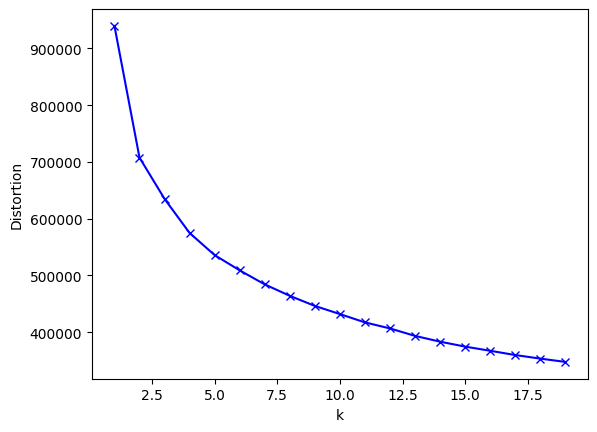

In [18]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ny[feat_cols])
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

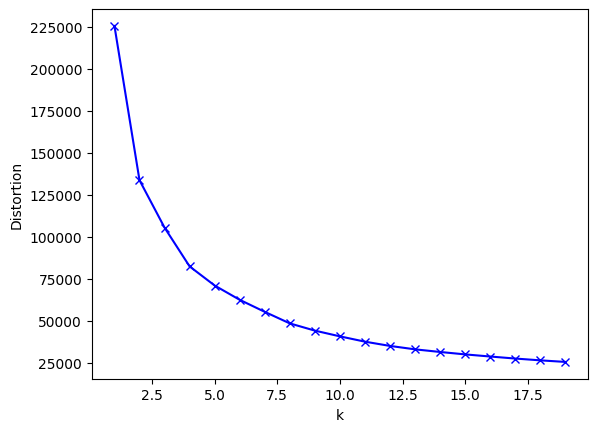

In [53]:
#lc 2 + 5
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ny[feat_subset])
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

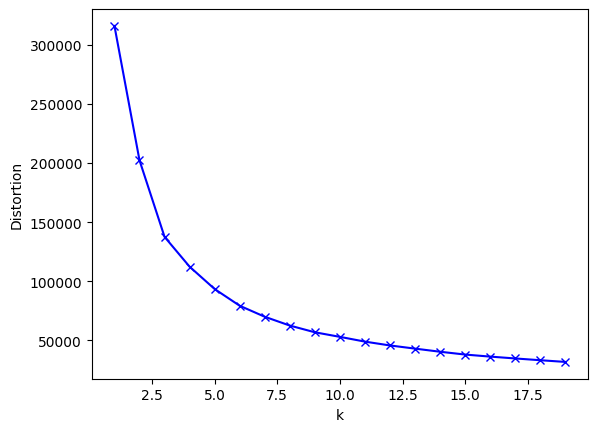

In [54]:
#grouped land cover vars
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ny[feat_subset_agg])
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

In [55]:
#range: [-1,1], 1 is best, close to 0 indicates overlapping clusters, negative indicates values assigned to wrong cluster
def cv_silhouette_score(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)

In [56]:
# ny.columns

# Clustering Methods

In [57]:
feat_data = ny.set_index('bctcb2020').drop(columns = ['cb2020','borocode','boroname','ct2020','geoid','shape_leng','shape_area','geometry','ntaname'])

In [58]:
def model_train_eval(model_obj, X, cv = False, params = None):

    model = model_obj.fit(X)
        # core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
        # core_samples_mask[model.core_sample_indices_] = True
    labels = model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))

### Agglomerative

In [59]:
#LC 2 + 5
n_clusters = [4,5,6]
for n in n_clusters:
    ac = AgglomerativeClustering(n_clusters = n)
    model_train_eval(ac, feat_data[feat_subset])
    print('-'*15)

Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: 0.277
---------------
Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.227
---------------
Estimated number of clusters: 6
Estimated number of noise points: 0
Silhouette Coefficient: 0.266
---------------


In [60]:
#grouped LC vars
n_clusters = [4,5,6]
for n in n_clusters:
    ac = AgglomerativeClustering(n_clusters = n)
    model_train_eval(ac, feat_data[feat_subset_agg])
    print('-'*15)

IOStream.flush timed out


Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: 0.276
---------------
Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.294
---------------
Estimated number of clusters: 6
Estimated number of noise points: 0
Silhouette Coefficient: 0.315
---------------


### DBSCAN

In [93]:
#LC 2+5
eps =[0.3,0.4,0.5]
min_samples = [60]
for e in eps:
    for m in min_samples:
        print(f'Max dist:{e}, min samples:{m}')
        model_train_eval(DBSCAN(eps = e, min_samples = m), feat_data[feat_subset])
        print('-'*15)

Max dist:0.3, min samples:60
Estimated number of clusters: 2
Estimated number of noise points: 11558
Silhouette Coefficient: 0.133
---------------
Max dist:0.4, min samples:60
Estimated number of clusters: 3
Estimated number of noise points: 5871
Silhouette Coefficient: 0.222
---------------
Max dist:0.5, min samples:60
Estimated number of clusters: 1
Estimated number of noise points: 3545
Silhouette Coefficient: 0.455
---------------


In [117]:
#LC grouped
eps =[0.55,0.6,0.65]
min_samples = [200]
for e in eps:
    for m in min_samples:
        print(f'Max dist:{e}, min samples:{m}')
        model_train_eval(DBSCAN(eps = e, min_samples = m, metric = 'canberra'), feat_data[feat_subset_agg])
        print('-'*15)

Max dist:0.55, min samples:200
Estimated number of clusters: 5
Estimated number of noise points: 18674
Silhouette Coefficient: 0.133
---------------
Max dist:0.6, min samples:200
Estimated number of clusters: 4
Estimated number of noise points: 16343
Silhouette Coefficient: 0.181
---------------
Max dist:0.65, min samples:200
Estimated number of clusters: 5
Estimated number of noise points: 14357
Silhouette Coefficient: 0.046
---------------


In [108]:
#grouped LC vars
eps =[0.3,0.45,0.6]
min_samples = [35,75]
for e in eps:
    for m in min_samples:
        print(f'Max dist:{e}, min samples:{m}')
        model_train_eval(DBSCAN(eps = e, min_samples = m), feat_data[feat_subset_agg])
        print('-'*15)

Max dist:0.3, min samples:35
Estimated number of clusters: 2
Estimated number of noise points: 10285
Silhouette Coefficient: 0.302
---------------
Max dist:0.3, min samples:75
Estimated number of clusters: 2
Estimated number of noise points: 14493
Silhouette Coefficient: -0.063
---------------
Max dist:0.45, min samples:35
Estimated number of clusters: 2
Estimated number of noise points: 4846
Silhouette Coefficient: 0.402
---------------
Max dist:0.45, min samples:75
Estimated number of clusters: 2
Estimated number of noise points: 6527
Silhouette Coefficient: 0.387
---------------
Max dist:0.6, min samples:35
Estimated number of clusters: 4
Estimated number of noise points: 2308
Silhouette Coefficient: 0.377
---------------
Max dist:0.6, min samples:75
Estimated number of clusters: 2
Estimated number of noise points: 3622
Silhouette Coefficient: 0.432
---------------


#### KMeans

In [32]:
n_clusters = [4,5,6]
for n in n_clusters:
    km = KMeans(n_clusters = n)
    model_train_eval(km, feat_data[feat_subset])
    print('-'*15)

Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: 0.251
---------------
Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.269
---------------
Estimated number of clusters: 6
Estimated number of noise points: 0
Silhouette Coefficient: 0.242
---------------


In [33]:
#grouped LC vars
n_clusters = [4,5,6]
for n in n_clusters:
    km = KMeans(n_clusters = n)
    model_train_eval(km, feat_data[feat_subset_agg])
    print('-'*15)

Estimated number of clusters: 4
Estimated number of noise points: 0
Silhouette Coefficient: 0.309
---------------
Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.285
---------------
Estimated number of clusters: 6
Estimated number of noise points: 0
Silhouette Coefficient: 0.293
---------------


### Affinity Propagation

In [47]:
# damping = [0.75, 0.9]
# for d in damping:
#     print(f'Damping factor:{d}')
#     ap = AffinityPropagation(damping = d, max_iter = 25, convergence_iter = 10)
#     model_train_eval(ap, feat_data[feat_subset])
#     print('-'*15)

## DBSCAN Maps

In [79]:
db = DBSCAN(eps = 0.6, min_samples = 50).fit(feat_data[feat_subset_agg])
np.unique(db.labels_, return_counts=True)

(array([-1,  0,  1,  2]), array([ 2898, 34536,   105,    50]))

In [115]:
db = DBSCAN(eps = 0.6, min_samples = 35).fit(feat_data[feat_subset_agg])
np.unique(db.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([ 2308, 34911,   109,   117,   144]))

In [80]:
# db = DBSCAN(eps = 0.75, min_samples = 9).fit(feat_data[feat_subset])
# np.unique(db.labels_, return_counts=True)

In [81]:
# db = DBSCAN(eps = 1.125, min_samples = 11).fit(feat_data[feat_subset_agg])
# np.unique(db.labels_, return_counts=True)

In [ ]:
feat_data['cluster_db'] = db.labels_

In [26]:
# feat_data['cluster_db3'] = db3.labels_

In [24]:
# feat_data['cluster_db5'].value_counts()

 0    37419
-1      100
 3       51
 4        8
 2        7
 1        4
Name: cluster_db5, dtype: int64

In [27]:
# feat_data['cluster_db3'].value_counts()

 0    37306
-1      232
 2       44
 1        7
Name: cluster_db3, dtype: int64

#### Sample model analysis

In [42]:
ny[feat_subset].agg([np.min, np.max, np.mean])

,imperv_cvr,perm_cvr,elev_q1,elev_q1_ct,elev_mean,elev_min,catch_basin_density
amin,-5.186843e+00,-2.231645e+00,-1.158896e+00,-1.162515e+00,-1.193003e+00,-1.047873e+00,-1.063884e+00
amax,3.569699e+00,7.799597e+00,8.084824e+00,7.050631e+00,7.890981e+00,8.197236e+00,2.495880e+01
mean,-3.629365e-16,-9.678307e-17,-9.678307e-17,-6.048942e-17,1.693704e-16,1.209788e-17,-1.209788e-17


In [48]:
db = DBSCAN(eps = 1, min_samples = 11).fit(feat_data[feat_subset])

In [49]:
np.unique(db.labels_, return_counts = True)

(array([-1,  0,  1]), array([  425, 37117,    47]))

In [73]:
feat_data['cluster_db'] = db.labels_

In [74]:
feat_data.cluster_db.value_counts()

 0    33011
-1     4459
 2       45
 1       42
 3       32
Name: cluster_db, dtype: int64

In [75]:
feat_data.groupby('cluster_db')[feat_subset].agg([np.min, np.max, np.mean, np.median]).transpose()

cluster_db               -1         0         1         2         3
elev_q1    amin   -1.158896 -1.158896  3.001960  2.718265  2.009029
           amax    8.084824  2.340006  3.427502  3.214731  2.410930
           mean    1.472298 -0.209216  3.233869  2.994605  2.215151
           median  1.347074 -0.378735  3.238372  3.001960  2.221800
elev_q1_ct amin   -1.162515 -1.162515  3.305223  2.930682  1.753553
           amax    7.050631  2.850423  3.760022  3.358729  2.529388
           mean    1.234094 -0.177577  3.484849  3.160757  2.205009
           median  1.031225 -0.386680  3.438987  3.171458  2.235106
elev_mean  amin   -1.193003 -1.193003  2.951780  2.698488  1.927098
           amax    7.890981  2.366905  3.446852  3.218889  2.295523
           mean    1.514107 -0.214642  3.173110  2.948710  2.130811
           median  1.372157 -0.380165  3.175138  2.960991  2.132034
elev_min   amin   -1.047873 -1.047873  3.134438  2.840943  2.205036
           amax    8.197236  2.351784  3.623597  3.379018  2.620821
           mean    1.365523 -0.195241  3.383094  3.061064  2.386942
           median  1.275633 -0.387508  3.403476  3.085522  2.400699
land_cvr_2 amin   -0.898252 -0.898252 -0.898252  0.831760 -0.898252
           amax    9.108946  6.437118 -0.569951  1.590715 -0.604799
           mean    0.655309 -0.088235 -0.855853  1.208482 -0.866285
           median  0.437647 -0.425562 -0.878688  1.175205 -0.898252
land_cvr_5 amin   -1.680086 -1.680086  0.891781 -0.849711 -1.680086
           amax    4.815769  3.394619  1.591083 -0.062290 -1.680086
           mean   -0.530958  0.072336  1.223688 -0.399258 -1.680086
           median -0.581999  0.040629  1.237973 -0.364885 -1.680086

#### Sample model analysis 2

In [29]:
dbl = DBSCAN(eps = 1, min_samples = 9).fit(feat_data[feat_subset])
feat_data['cluster_dbl'] = dbl.labels_
feat_data['cluster_dbl'].value_counts()

 0    37211
-1      294
 4       45
 1       12
 3        9
 2        9
 5        9
Name: cluster_dbl, dtype: int64

In [27]:
ny[feat_subset].agg([np.min, np.max, np.mean])

,imperv_cvr,perm_cvr,elev_q1,elev_q1_ct,elev_mean,elev_min
amin,-5.186843e+00,-2.324327,-1.158896e+00,-1.162515e+00,-1.193003e+00,-1.047873e+00
amax,3.569699e+00,26.729540,8.084824e+00,7.050631e+00,7.890981e+00,8.197236e+00
mean,-3.629365e-16,0.000000,-9.678307e-17,-6.048942e-17,1.693704e-16,1.209788e-17


In [28]:
feat_data.groupby('cluster_dbl')[feat_subset].agg([np.min, np.max, np.mean, np.median]).transpose()

cluster_dbl               -1          0         1
imperv_cvr amin    -5.186843  -5.186843 -1.691778
           amax     1.768872   3.569699  0.552859
           mean    -2.707448   0.027871 -0.718448
           median  -3.068579   0.302459 -0.690582
perm_cvr   amin    -2.324327  -2.324327 -0.232429
           amax    26.729540  12.205889  2.281357
           mean     6.145121  -0.062681  1.142169
           median   4.075329  -0.339419  1.189775
elev_q1    amin    -1.158896  -1.158896  4.491358
           amax     8.084824   5.460648  6.240808
           mean     1.977741  -0.026059  5.340292
           median   1.701693  -0.284170  5.389724
elev_q1_ct amin    -1.162515  -1.162515  5.472209
           amax     7.050631   4.509104  5.739738
           mean     1.469006  -0.021260  5.575573
           median   0.843954  -0.306421  5.472209
elev_mean  amin    -1.193003  -1.193003  4.439297
           amax     7.890981   5.381084  6.265304
           mean     2.063755  -0.026857  5.289396
           median   1.934006  -0.273091  5.277464
elev_min   amin    -1.047873  -1.047873  4.406252
           amax     8.197236   5.629150  6.240599
           mean     1.601959  -0.022430  5.442936
           median   1.031054  -0.289676  5.482402

In [27]:
db2 = DBSCAN(eps = 1, min_samples = 7).fit(feat_data[feat_subset])
feat_data['cluster_db6'] = db2.labels_

In [24]:
ny = ny.set_index('bctcb2020')

In [30]:
df = ny[['cb2020','borocode','boroname','ct2020','geoid','shape_leng','shape_area','geometry','ntaname']].join(feat_data[['cluster_db4','cluster_db6']])
df.head()

,cb2020,borocode,boroname,ct2020,geoid,shape_leng,shape_area,geometry,ntaname,cluster_db4,cluster_db6
bctcb2020,,,,,,,,,,,
10001001000,1000,1,Manhattan,100,360610001001000,2.563287,1.028343,"POLYGON ((973172.666 194632.348, 973310.630 19...",The Battery-Governors Island-Ellis Island-Libe...,0,0
10001001001,1001,1,Manhattan,100,360610001001001,1.328588,0.436533,"POLYGON ((972081.788 190733.467, 972184.766 19...",The Battery-Governors Island-Ellis Island-Libe...,0,0
10002011000,1000,1,Manhattan,201,360610002011000,-0.234124,-0.099464,"POLYGON ((988376.731 199328.618, 987837.811 19...",Chinatown-Two Bridges,0,0
10002011001,1001,1,Manhattan,201,360610002011001,-0.220366,-0.088884,"POLYGON ((988392.400 199070.298, 988285.301 19...",Chinatown-Two Bridges,0,0
10002012000,2000,1,Manhattan,201,360610002012000,0.034592,0.041155,"POLYGON ((988422.186 198807.188, 988449.289 19...",Chinatown-Two Bridges,0,0


In [ ]:
df.to_csv('clusters_all.csv')
!aws s3 cp clusters_all.csv s3://w210-flood-risk/clusters_all.csv --acl public-read

In [2]:
df = pd.read_csv('s3://w210-flood-risk/clusters_all.csv')

FileNotFoundError: w210-flood-risk/clusters_all.csv

<AxesSubplot: >

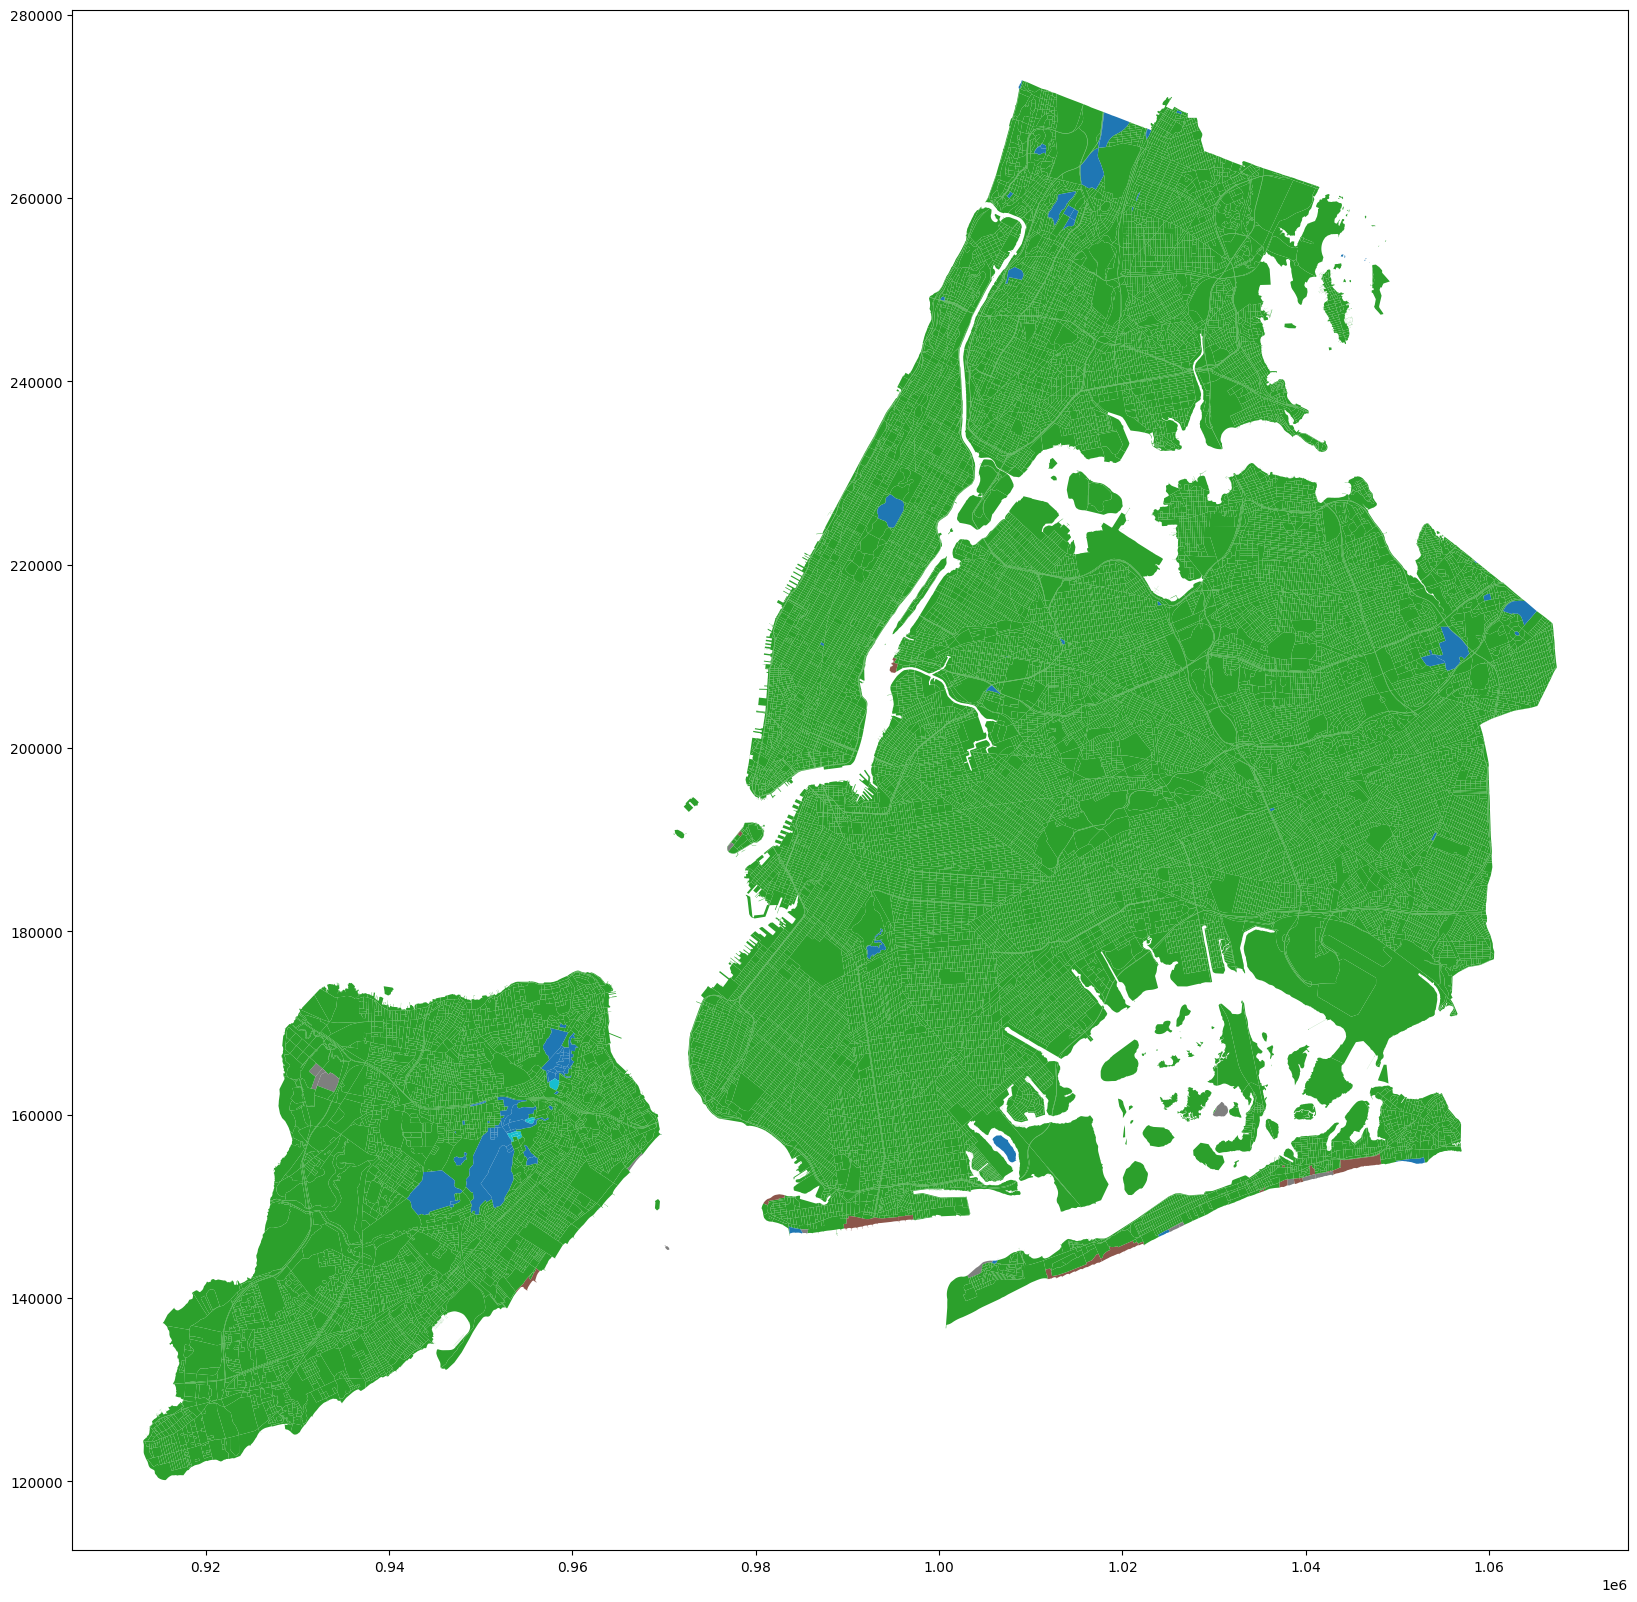

In [31]:
df.plot(column = 'cluster_db4',
        categorical=True,
        figsize = (25, 20))

<AxesSubplot: >

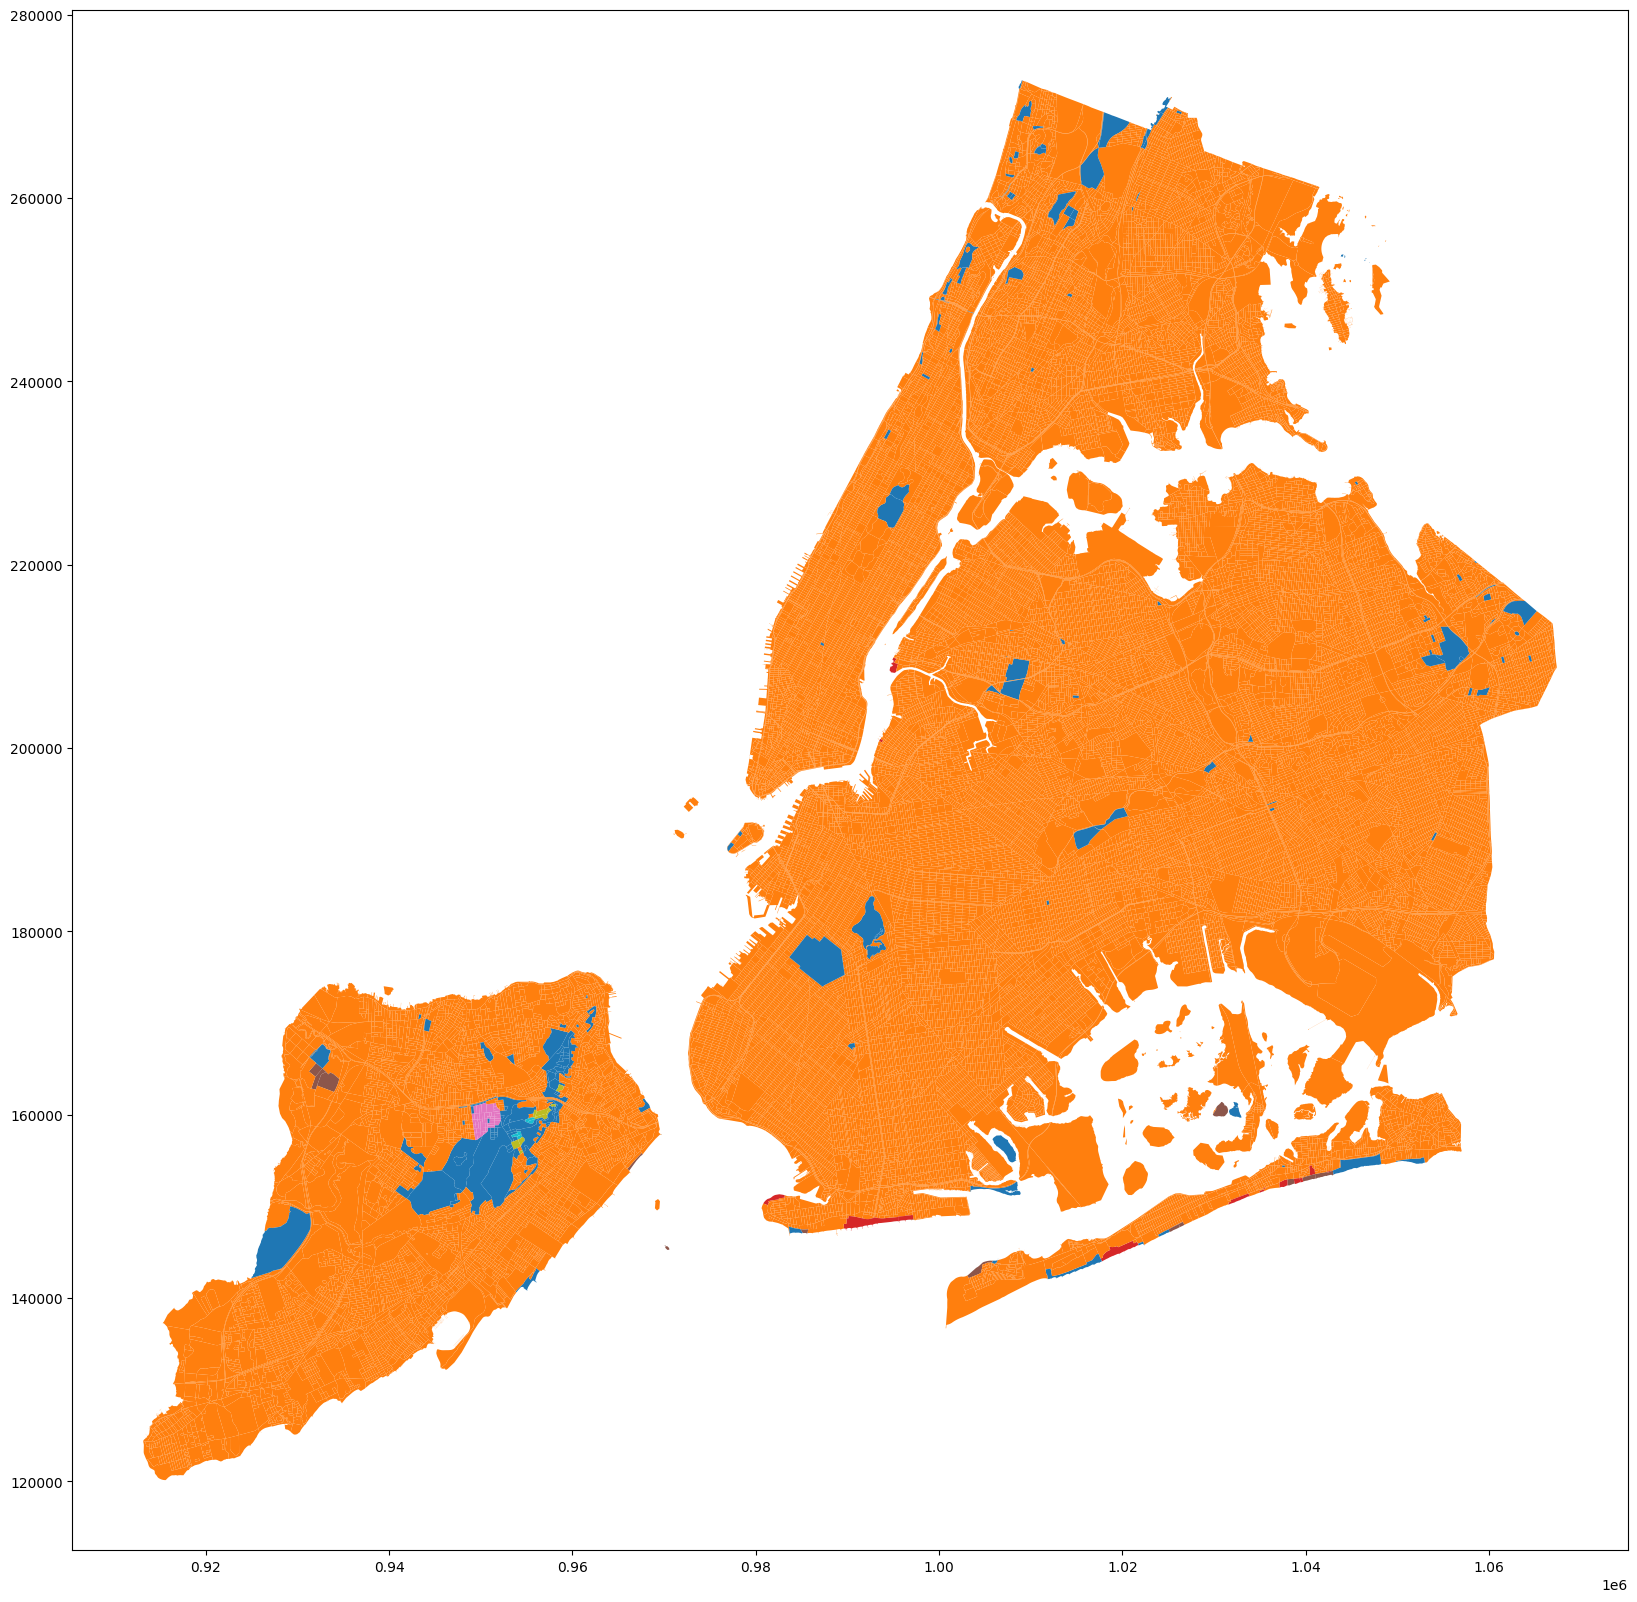

In [32]:
df.plot(column = 'cluster_db6',
        categorical=True,
        figsize = (25, 20))

### Visualizations

In [21]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


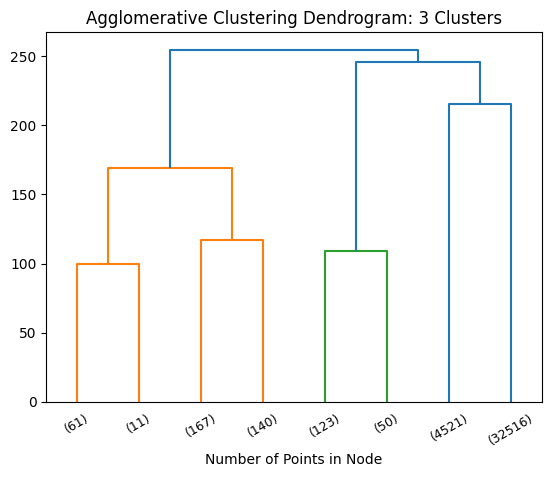

In [39]:
plt.title('DBSCAN Clustering Dendrogram: 3 Clusters')
plot_dendrogram(ac, truncate_mode = 'level', p = 2, leaf_rotation = 30, leaf_font_size = 9)
plt.xlabel('Number of Points in Node')
plt.show()